# Big Idea

I made this pet project to improve at:
* __aesthetics:__ markdown, matplotlib, structure, design
* __modeling:__ cross validation to detect underfitting and underfitting, new models, remedial measures, bring more stats
* __code:__ EDA
* __design:__ explanations of the steps

# Preliminaries

## Libraries

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import  mean_squared_error as mse

## Misc

In [99]:
from pandas.core.common import SettingWithCopyWarning
import warnings

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## Data

In [100]:
insurance = pd.read_csv(r"C:\Users\Henryk-Mariusz\Desktop\Spyder Scripts\datasets\insurance\insurance.csv")

# EDA

In [101]:
insurance.shape

(1338, 7)

In [102]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [103]:
insurance.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

The dataset `insurance` contains nearly 1400 observations across 7 different features with all of the features properly labeled with the respect to `.dtypes` and descriptive names

## Numerical features

In [104]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The `count` tells the amount of values excluding `np.nan`, which tells me there aren't any missing values

__Here are some observations:__
* `age` which reports an age of a patient is roughly 39, with voting age 18 as min while the oldest is 64
* `bmi` reports body mass index, which in this example tells how "fit" a person is
* `childre` most patients have 1 child, with max of 5
* `charges` relate to the total bill at the hospital with `mean` and `median` significantly apart from each other; which is an indicator of skeweness

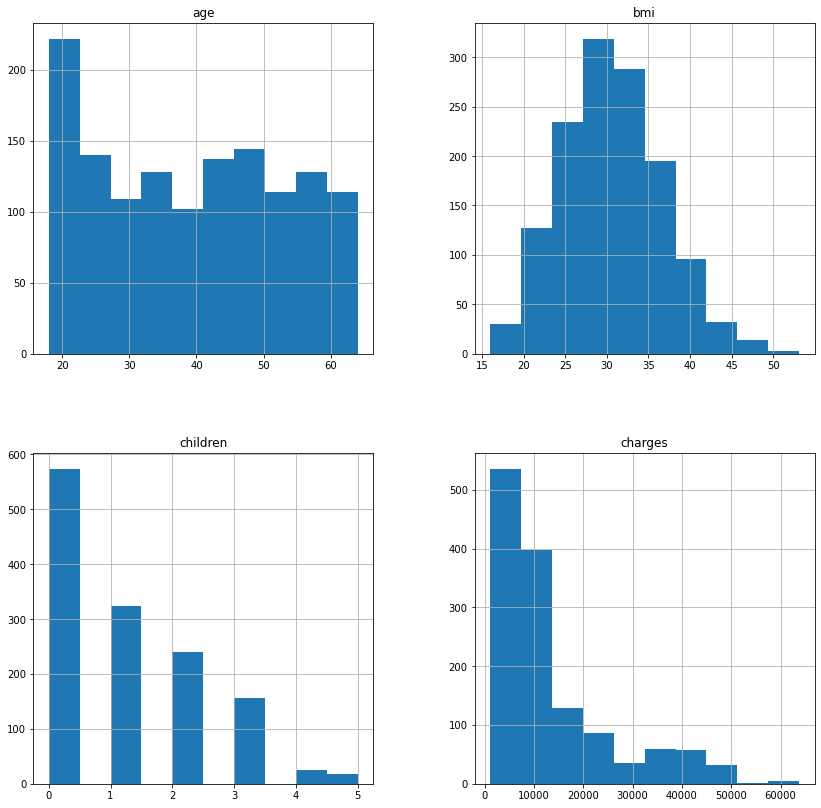

In [105]:
insurance.hist(figsize=(14,14))
plt.show()

__There are some significant patterns worth mentioning:__
* `age` seems uniformly distributed, with an exception of the most people with most patients around age of 20
* `bmi` seems to be uniformly distributed, with a positive skew
* `children` are dicrete, exponentially distributed with msot people having no children; as probably related to young age
* `charges` which mostly relate around low cost, but the positive skew indicating that there are people that paid a lot, I'll apply a transformation to improve normality

## Categorical features

Lets investigate features that were not displayed by the previous commands

In [106]:
insurance.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


__We can see that we have:__
* `sex` two categories
* `smoker` two categories
* `region` 4 categories
>what's the point of all of this? bring more info

Lets look at their distributions!
>more insight, different tone

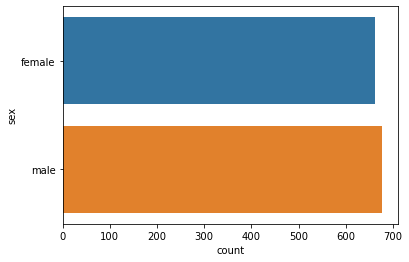

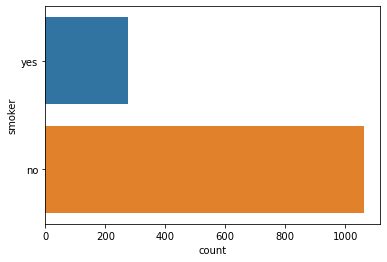

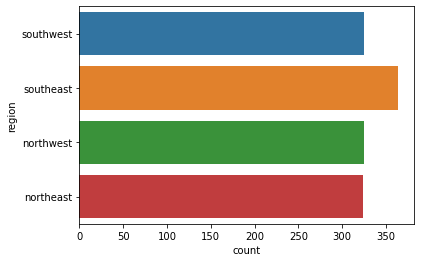

In [107]:
for column in insurance.select_dtypes(include='object'):
        sns.countplot(y=column, data=insurance) # all of them got less than 10 categories
        plt.show()

`sex` and `region` seems balanced while `smoker` isn't, the lack of equality between groups may affect it's power of explaining `charges`. In the worst case scenario the feature will be insignificant or regularization in LASSO will reduce it to 0

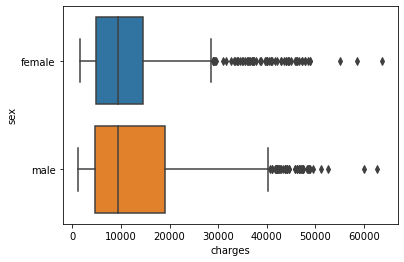

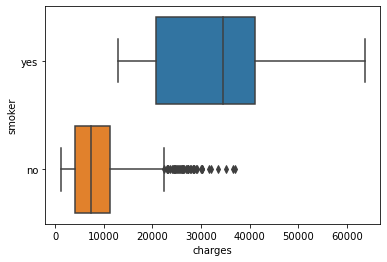

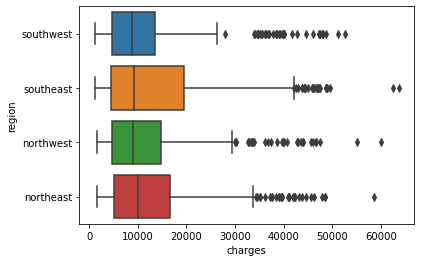

In [108]:
for column in insurance.select_dtypes(include='object'):
    sns.boxplot(data=insurance, y=column, x='charges')
    plt.show()

I don't see all the patterns yet but I'll comment and discover it as I go along:
* `smoker` categorical boxplots seem to have 2 significanly different distributions but `smoker=No=0` have outliers that paid significatly more. Furthermore, on the same note `smoker=Yes=1` don't have outliers in the group of `smoker=No=0`
*`region=southeast` seem to have more and stronger outliers, I wonder if scaling, power transforming features on the category level would improve the model?

### Are smokers spending more on healthcare?

As this is a tutorial project, I'd like to do it right and test ANOVA's assumptions first which are similar to regression assumptions, as underneath ANOVA there's a regression model as described on [Cross Validated](https://stats.stackexchange.com/questions/1637/if-the-t-test-and-the-anova-for-two-groups-are-equivalent-why-arent-their-assu "https://stats.stackexchange.com/questions/1637/if-the-t-test-and-the-anova-for-two-groups-are-equivalent-why-arent-their-assu"), [ANOVA tutorial in Python](https://www.reneshbedre.com/blog/anova.html"https://www.reneshbedre.com/blog/anova.html")

__Assumptions:__
* Homoscadacity aka simliar variance 
* Normality of each group
* Independence of observations

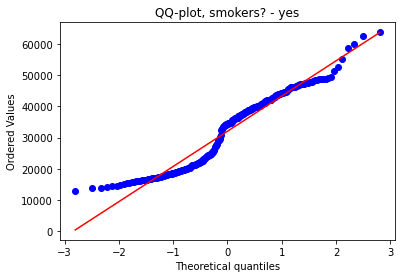

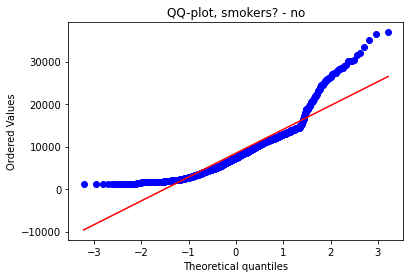

In [109]:
is_smoker = insurance['smoker'].unique()
for group in is_smoker:
    stats.probplot(insurance[insurance['smoker'] == group]['charges'], dist="norm", plot=plt)
    plt.title("QQ-plot, smokers? - " +  group)
    plt.show()

#make a function from that, is there a qq-plot in statsmodel?

Doesn't look normal to me. But the good news is that ANOVA is a robust in regards to normality. What does robust mean? Also, I could do Wilk-Shapiro, but it had some restriction about the size

## Relationship plots

In [110]:
insurance_corr = insurance.corr()

<AxesSubplot:>

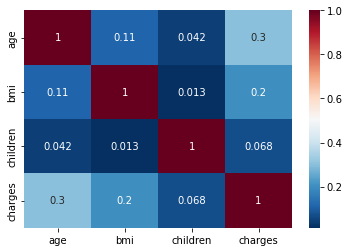

In [111]:
sns.heatmap(insurance_corr, cmap='RdBu_r', annot=True)

There doesn't seem to exist a strong relationship between the numerical features, and the strongest relationship exists between `charges` vs `age`. It might be difficult to create a good model with high r_square

## Dividing data into train and test

The data should be devided in two sets, __train__ and __test__ to see how's the model performing on an unseen data

In [112]:
X, y = insurance.drop(['charges'], axis=1), insurance.charges

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Pipeline

Now that I explored the data, it's time to create a `Pipeline` to stream line the process of exploration

In [114]:
num_cols = list(X_train[['age','bmi']].columns)

In [115]:
cat_cols = list(X_train[['sex','smoker','region','children']].columns)

The pipeline does different transformation according to the category of a feature, hence `num_cols` and `cat_cols`

In [116]:
num_pipe = Pipeline([
    ('scale', StandardScaler())
])

In [117]:
full_pipe = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

In [118]:
X_train_trans = full_pipe.fit_transform(X_train)

Now with the data ready for the project it's time to select a set of best performing algorithms and compare it to the baseline

# Models

Since this is a regression model, the very first I'd like to do is fit the most basic model and keep it as a baseline of performance to measure all the other, more advanced algorithms

## Baseline

For the baseline model I'll use `LinearRegression` model 

In [119]:
lin_reg = LinearRegression()

In [120]:
lin_reg.fit(X_train_trans, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The model is ready for interpretation! 

In [121]:
y_train_predict = lin_reg.predict(X_train_trans)

In [122]:
r2_score(y_train, y_train_predict)

0.7432126559011109

In [123]:
mse(y_train, lin_reg_predict, squared=False)

6087.942792141382

The model is ready, however, it will take a lot of time to fully process the 

### Log response

The response variable is skewed, I want to see if applying a log transform would improve the situation

In [124]:
lin_reg_log = LinearRegression()

In [125]:
lin_reg_log.fit(X_train_trans, y_train_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [126]:
y_train_log_pred = lin_reg_log.predict(X_train_trans)

In [127]:
y_train_log = np.log(y_train)

In [128]:
r2_score(y_train_log, y_train_log_pred)

0.7597504536055103

In [130]:
lin_reg_log.score(X_train_trans, y_train_log)

0.7597504536055103

I want to remove the code from below, it's about 

In [132]:
from sklearn.linear_model import LogisticRegression

In [136]:
clf = LogisticRegression()

In [133]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [134]:
df = insurance.copy()

In [ ]:
df['sex'].replace(0, 'Female',inplace=True)
df['sex'].replace(1, 'Male',inplace=True)

In [143]:
y_clf, X_clf = df['sex'], df.drop(['sex'], axis=1, inplace=False)

In [141]:
num_cols_clf, cat_cols_clf = ['age','bmi','charges'], ['children','region']

In [149]:
full_pipe_clf = ColumnTransformer([
    ('num', num_pipe, num_cols_clf),
    ('cat', OneHotEncoder(), cat_cols_clf)
])

In [146]:
df_piped = full_pipe_clf.fit_transform(X_clf)

In [147]:
clf.fit(df_piped, y_clf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [148]:
clf.score(df_piped, y_clf)

0.515695067264574

## Wide search for the best model

# Conclusion